# NOTE

- Make a copy of this template before you start editing, and exported the file as a ipynb where you are done.

- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Runtime$\rightarrow$Factory reset runtime) and then **run all cells** (in the menubar, select Runtime$\rightarrow$Run all).

- Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Fill out your name below in the `NAME` variable, leave the `COLLABORATORS` variable empty.

In [489]:
NAME = "Ritesh Reddy"
COLLABORATORS = ""

---

# Homework 4

## Copy number callers



In this homework assignment we will develop a copy number caller based on a Hidden Markov Model. In addition, we will implement a hierarchical clustering algorithm. The data that we consider is from a previously published [breast tumor](http://dx.doi.org/10.1038/nature09807), from which 100 single cells have been sequenced. In this homework assignment we restrict our attention to a subset of 25 cells.

_Instructions:_ There are four questions, worth a total of 100 points. In addition, there are two bonus questions (Q2e and Q4c), each worth 5 points. Insert your answer after each question in the designated box. Replace comments with code.


In [490]:
# Install library and download data

! pip install nose

! wget -c 'https://www.dropbox.com/s/8oa07hlhbxylhvp/HW4_supplement.zip?dl=1' -O data.zip
! unzip -o data.zip

--2020-11-19 20:51:26--  https://www.dropbox.com/s/8oa07hlhbxylhvp/HW4_supplement.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/8oa07hlhbxylhvp/HW4_supplement.zip [following]
--2020-11-19 20:51:27--  https://www.dropbox.com/s/dl/8oa07hlhbxylhvp/HW4_supplement.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbb616b97948402b20d023a3cc7.dl.dropboxusercontent.com/cd/0/get/BDhOem61tG3GcJ5BGD6KP8S5N8LNx6jlCeo4X0pHWc4bKvfgJIN2ddAuCX1TAQKB4rhsdToBQHnJ4JkeHD7YnTJyZfWHkDjdWqEmAWjjl0HWVXd51wC9l7VyYgiHzEVbCgs/file?dl=1# [following]
--2020-11-19 20:51:27--  https://ucbb616b97948402b20d023a3cc7.dl.dropboxusercontent.com/cd/0/get/BDhOem61tG3GcJ5BGD6KP8S5N8LNx6jlCeo4X0pHWc4bKvfgJIN2ddAuCX1TAQKB4rhsdToBQHnJ4JkeHD7YnTJyZfWHkD

In [491]:
import copy
import sys

import nose.tools as nt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import norm
from scipy.cluster import hierarchy

## Question 1: Data preparation [20 points]

We start by parsing the data from `data.tsv` using pandas.

In [492]:
df = pd.read_csv("data.tsv", sep="\t", index_col=0)
df.head()

,CHR,START,END,SRR089377,SRR054598,SRR053605,SRR054594,SRR089397,SRR054614,SRR089402,SRR053676,SRR053633,SRR053617,SRR054608,SRR053608,SRR054602,SRR089401,SRR053668,SRR054606,SRR054613,SRR053631,SRR054575,SRR053679,SRR054604,SRR053611,SRR053607,SRR053602,SRR054610
bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,chr1,1,1246396,2116,298,573,157,3146,1495,4071,815,2492,2484,1387,1299,1470,2525,824,854,1583,1106,1847,795,562,1211,636,751,1520
1,chr1,1246395,1833664,1940,264,660,204,1643,1207,3809,736,1608,983,841,623,565,2876,806,651,848,1252,2024,830,584,836,475,673,1185
2,chr1,1833663,2345598,1767,261,870,237,1655,1621,5418,966,1929,1077,1029,779,898,3505,1109,707,1372,1342,2531,1153,874,936,630,818,1366
3,chr1,2345597,2946628,2246,446,854,265,1564,1838,5625,1121,2429,1677,1365,769,973,3188,1279,1227,1172,1578,2909,1373,884,1184,604,973,1701
4,chr1,2946627,3452945,2189,363,883,217,2081,1173,4845,1053,1790,1170,1192,700,854,3206,963,687,1371,1562,3235,1053,854,785,649,784,1212


This dataset consists of the following 25 cells:

In [493]:
cells = list(df.columns[3:])
sys.stdout.write("Cells:")
for idx, cell in enumerate(cells):
    if idx % 5 == 0:
        sys.stdout.write("\n")
    sys.stdout.write(cell + " ")

Cells:
SRR089377 SRR054598 SRR053605 SRR054594 SRR089397 
SRR054614 SRR089402 SRR053676 SRR053633 SRR053617 
SRR054608 SRR053608 SRR054602 SRR089401 SRR053668 
SRR054606 SRR054613 SRR053631 SRR054575 SRR053679 
SRR054604 SRR053611 SRR053607 SRR053602 SRR054610 

The reads of each cell are put in bins. As seen in the command below, there are 5363 bins.

In [494]:
len(df.index)

5363

We plot a histogram of the bin sizes as follows, from which we can see that most of the bins have length 500,000.

(400000.0, 1000000.0)

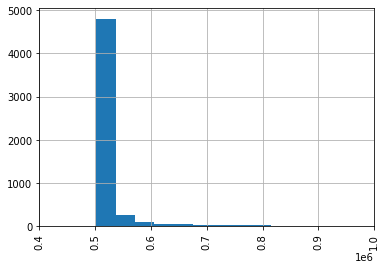

In [495]:
(df['END'] - df['START'] + 1).hist(bins=1000, xrot=90)
plt.xlim((400000, 1000000))

### _Q1a:_ What is the minimum, median and maximum bin size? [4 points]

Set the values of `minimum`, `median`, and `maximum` according to the minimum, median and maximum bin size.

In [496]:
minimum, median, maximum = None, None, None
maximum = max(df['END'] - df['START'] + 1)
minimum = min(df['END'] - df['START'] + 1)
median = 0
if len(df['END'] - df['START'] + 1) % 2 != 0:
  median = sorted(df['END'] - df['START'] + 1)[len(df['END'] - df['START'] + 1)//2]
else:
  median = 0.5*( sorted(df['END'] - df['START'] + 1)[len(df['END'] - df['START'] + 1)//2] + sorted(df['END'] - df['START'] + 1)[len(df['END'] - df['START'] + 1)//2 + 1] )

# YOUR CODE HERE
# raise NotImplementedError()

In [497]:
# HIDDEN TEST CELL DO NOT MODIFY


In [498]:
# HIDDEN TEST CELL DO NOT MODIFY


In [499]:
# HIDDEN TEST CELL DO NOT MODIFY


We retain bins with lengths between 450,000 and 500,000 using the following command.

In [500]:
df = df[(450000 <= (df['END'] - df['START'] + 1)) & ((df['END'] - df['START'] + 1) <= 550000)]

### _Q1b:_ The column `CHR` contains the chromosome label. Do these cells originate from a male or female patient? [4 points]

Write code here to print unique list of values in `'CHR'` column, this should give you the information you need.

Set the value of `is_female` to `True` or `False` based on the answer to this question.

In [501]:
is_female = None
if 'chrY' in df['CHR'].unique():
  is_female = False
else:
  is_female = True
# YOUR CODE HERE
# raise NotImplementedError()

In [502]:
# HIDDEN TEST CELL DO NOT MODIFY


Next, we remove the sex chromosomes such that each bin in a normal cell has copy number 2.

### _Q1c:_ How many bins occur on autosomal chromosomes? [4 points]

Insert code to generate a list of chromosome labels corresponding to autosomes, e.g. `['chr1', 'chr2', ...]`.

The value of `autosomal_bins` is set to the number of bins that are in this list.

In [503]:
# Make a list of autosomes
autosomes = None
autosomes = df['CHR'].unique()[:len(df['CHR'].unique())-2]
# YOUR CODE HERE
# raise NotImplementedError()

autosomal_bins = len(df[df['CHR'].isin(autosomes)])

In [504]:
# HIDDEN TEST CELL DO NOT MODIFY


In [505]:
# Now retain only autosomes
df_auto = df[df['CHR'].isin(autosomes)]

Due to variablity in library preparation, there are differences in the total number of reads per cell. We construct a new dataframe with the total number of reads, and plot a histogram as follows.

        cell    total
0  SRR089377  9584016
1  SRR054598  1784898
2  SRR053605  3807854
3  SRR054594  1361308
4  SRR089397  8634326


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f97733508d0>]],
      dtype=object)

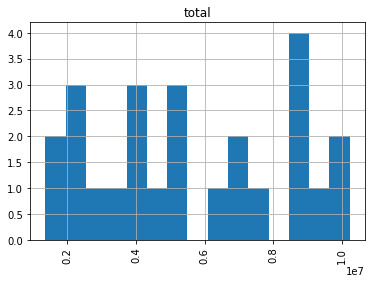

In [506]:
df_total_reads = pd.DataFrame.from_records([(cell, int(df_auto[cell].sum())) for cell in cells], columns=['cell', 'total'])
print(df_total_reads.head())
df_total_reads.hist(column="total", bins=15, xrot=90)

### _Q1d:_ Based on the above plot, we decide to exclude the six cells with a total read count of less than 3,000,000 reads. Which six cells are excluded? [4 points]

You are given the code for the cells that we include.

Set `df_removed_cells` to a DataFrame corresponding to the excluded cells, i.e. those with total read count of less than 3,000,000 reads. Note the type of `df_removed_cells` is not the same as that of `cells_to_keep`, which is a list. Rather, `df_removed_cells` is a DataFrame with two columns `'cell'` representing the name of the cell and `'total'` corresponding with the total read count of that cell.

Specifically, it should be the case that:
    `type(df_removed_cells) == type(df_total_reads)`

In [507]:
# insert code to filter down to cells with less 3,000,000 reads

cells_to_keep = list(df_total_reads[df_total_reads['total'] >= 3000000]['cell'])
df_removed_cells = None
df_removed_cells = df_total_reads
df_removed_cells = df_removed_cells.set_index('cell')
for i in cells_to_keep:
  df_removed_cells = df_removed_cells.drop(i,axis=0)
# YOUR CODE HERE
# raise NotImplementedError()

In [508]:
# HIDDEN TEST CELL DO NOT MODIFY


In [509]:
# we retain only cells with >= 300,000 reads
df_auto = df_auto[list(df_auto.columns)[:3] + cells_to_keep]

### _Q1e:_ Complete the below code fragment to identify the mode of each cell and to subsequently normalize the read counts. [4 points]

The key concept is that the majority of bins in a cell are diploid. Since the bins have the same length and under the assumption of uniform genome coverage, we expect the most frequent read count, or the mode, to correspond to the diploid state. We identify the mode by discretizing the read counts for each cell into 20 bins. We then divide the read count for each bin in a cell by the mode.

Make sure to discretize first prior to computing mode. The goal is to have 20 distinct values of reads counts per cell, this allows you to obtain the mode more robustly. To do so, for each cell, you must first identify the largest number of reads. Then, you divide the largest number of reads by 20 (use integer division). Then you need to round down your original number of reads to the nearest discretized number of reads (again possible using integer division).

Please put the result of dividing the read counts in `df_auto` into `df_filter`.

In [510]:
nr_bins = 20

# Use df2 to discretize read count
df2 = df_auto.copy(deep=True)

# Use df_filter to normalize
df_filter = df_auto.copy(deep=True)

for cell in cells_to_keep:
    # insert code to discretize read count (e.g. first integer division by bin_size, then multiply by bin_size)
    # YOUR CODE HERE
    max_bin = max(df2[cell])
    bin_size = max_bin // nr_bins
    df2[cell] = df2[cell].apply(lambda x: x//bin_size * bin_size)
    # raise NotImplementedError()

df_mode = pd.DataFrame.from_records([(cell, int(df2[cell].mode())) for cell in cells_to_keep], 
                                    columns=['cell', 'mode'])
# insert code to divide each read count in df_filter by the mode of the corresponding cell

for cell in cells_to_keep:
    mode = df_mode.loc[df_mode['cell'] == cell, 'mode'].iloc[0]
    df_filter[cell] = df_filter[cell].apply(lambda x: x/mode)
    # YOUR CODE HERE
    # raise NotImplementedError()

In [511]:
# HIDDEN TEST CELL DO NOT MODIFY


## Question 2: Viterbi algorithm [50 points]

In this question we use the Viterbi algorithm to compute a copy number for each bin. The set $Q$ of hidden states corresponds to integer copy numbers. We consider $Q=\{0,\ldots,10\}$. The set $\Sigma$ of emitted symbols are normalized read counts. Since this an infinite set, we use a probability distribution function for each integer copy number to define the emission probabilities. Specifically, for copy number $c \in \{0,\ldots,10\}$ we use a normal distribution with standard deviation $\sigma = 0.1$ centered around mean $\mu_c = c / 2$.

In [512]:
df_norm = pd.read_table("data_filtered_test.csv", sep="\t", index_col=0)

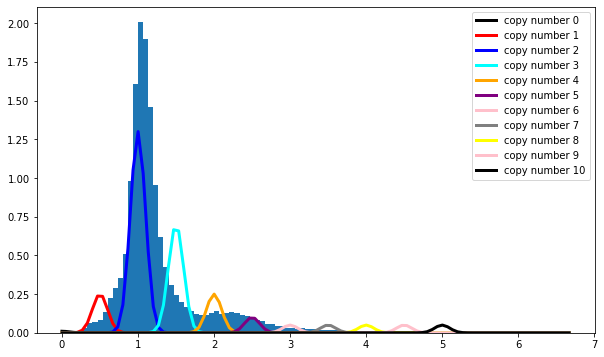

In [513]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

values = [val for sublist in [list(df_norm[cell]) for cell in list(df_norm.columns[3:])] for val in sublist]
count, bins, ignored = plt.hist(values, 100, density=True)

sigma = 0.1

plt.plot(np.array([0,.05,.1,.15,.2]),gauss(np.array([0,.05,.1,.15,.2]), 0, sigma, .01),color='black',lw=3,label='copy number 0')
plt.plot(bins,gauss(bins, 0.5, sigma, .25),color='red',lw=3,label='copy number 1')
plt.plot(bins,gauss(bins, 1, sigma, 1.3),color='blue',lw=3,label='copy number 2')
plt.plot(bins,gauss(bins, 1.5, sigma, .7),color='cyan',lw=3,label='copy number 3')
plt.plot(bins,gauss(bins, 2, sigma, .25),color='orange',lw=3,label='copy number 4')
plt.plot(bins,gauss(bins, 2.5, sigma, .1),color='purple',lw=3,label='copy number 5')
plt.plot(bins,gauss(bins, 3, sigma, .05),color='pink',lw=3,label='copy number 6')
plt.plot(bins,gauss(bins, 3.5, sigma, .05),color='gray',lw=3,label='copy number 7')
plt.plot(bins,gauss(bins, 4, sigma, .05),color='yellow',lw=3,label='copy number 8')
plt.plot(bins,gauss(bins, 4.5, sigma, .05),color='pink',lw=3,label='copy number 9')
plt.plot(bins,gauss(bins, 5, sigma, .05),color='black',lw=3,label='copy number 10')

plt.legend()
plt.gcf().set_size_inches(10, 6)

In [514]:
max_copy_number = 10

def emissionLogProb(copy_number, norm_count):
    sigma = 0.1
    mu = copy_number / 2.

    # Compute Pr(|X_c - norm_count| <= 0.01 | c)  
    low = norm.cdf(norm_count - 0.01, mu, sigma)
    up = norm.cdf(norm_count + 0.01, mu, sigma)
    
    # prevent probability of 0
    prob = max(up - low, 0.0001)
    
    return np.log(prob)

def transitionLogProb(current_copy_number, next_copy_number):
    stay_prob = 0.99999
    if current_copy_number == next_copy_number:
        return np.log(stay_prob)
    elif 0 <= next_copy_number <= max_copy_number:
        return np.log((1 - stay_prob) / max_copy_number)
    else:
        return np.log(0)

def initialLogProb(copy_number):
    if 0 <= copy_number <= max_copy_number:
        return np.log(1./11)
    else:
        return np.log(0)

### _Q2a:_ Compute the joint log probability of each cell having copy number 2 in all bins. [10 points]

_Hint:_ Make use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb` to set the values in the dictionary `joint_log_prob`. 

In [515]:
joint_log_prob = {k:0.0 for k in list(df_norm.columns[3:])}
for cell in list(df_norm.columns[3:]):
    log_prob = 0
    copy = 2
    for idx, norm_count in df_norm[cell].iteritems():
      if idx == df_norm.index[0]:
        log_prob += initialLogProb(copy) + emissionLogProb(copy, norm_count)
      else:
        log_prob += emissionLogProb(copy, norm_count) + transitionLogProb(copy, copy) 
        # Hint: idx == df_norm.index[0] is the initial item.
        # YOUR CODE HERE
        # raise NotImplementedError()
    joint_log_prob[cell] = log_prob

In [516]:
print(joint_log_prob)

{'SRR089377': -15135.070967101623, 'SRR053605': -15545.0612914526, 'SRR089397': -15308.765158061895, 'SRR054614': -34822.82444699966, 'SRR089402': -37630.92651885531, 'SRR053633': -17806.476991176896, 'SRR053617': -16345.74922800047, 'SRR054608': -28616.21503369759, 'SRR053608': -16321.14871395049, 'SRR054602': -29995.409906001376, 'SRR089401': -35739.67290677184, 'SRR053668': -23637.079259670103, 'SRR054606': -36717.05414486559, 'SRR054613': -28292.024336094033, 'SRR053631': -21570.613114390424, 'SRR054575': -34596.789039112264, 'SRR053611': -15312.762620957486, 'SRR053602': -18026.71904371433, 'SRR054610': -28578.42393018763}


In [517]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2b:_ Determine the maximum joint log probability of each cell using the Viterbi algorithm. [20 points]

Complete the function `viterbi`, making use of the functions `emissionLogProb`, `initialLogProb` and `transitionLogProb`.

Then complete the `max_joint_prob` function. The values in the `max_joint_probability` dictionary are filled in after you complete these two functions. This dictionary is autograded.

In [518]:
def viterbi(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    temp_bins = []
    for idx, bin in enumerate(bins):
      norm_count = float(df_norm.loc[bin][cell])
        # YOUR CODE HERE

      if bin == df_norm.index[0]:
        for s in Q:
          v[s][bin] = initialLogProb(s) + emissionLogProb(s, norm_count)
      else:
        for s in Q:
          max = float('-inf')
          for t in Q:
            if v[t][bins[idx-1]] > max:
              max = v[t][bins[idx-1]]
              v[s][bin] = emissionLogProb(s, norm_count) + max + transitionLogProb(t, s)
              
        # raise NotImplementedError()

    return v

def max_joint_prob(df_norm, v):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    # max_joint_probability = None
    max_joint_probability = float('-inf')
    for s in Q:
      if v[s][last_bin] > max_joint_probability:
        max_joint_probability = v[s][last_bin]
    # YOUR CODE HERE
    # raise NotImplementedError()
    
    return max_joint_probability

max_joint_probability = {}
V = {}
for cell in list(df_norm.columns[3:]):
    V[cell] = viterbi(df_norm, cell)
    max_joint_probability[cell] = max_joint_prob(df_norm, V[cell])
print(max_joint_probability)

{'SRR089377': -15135.07096710289, 'SRR053605': -15545.06129145379, 'SRR089397': -15308.765158063214, 'SRR054614': -34822.82444700404, 'SRR089402': -43323.49051788379, 'SRR053633': -17806.476991178395, 'SRR053617': -16345.749228001956, 'SRR054608': -28616.215033701294, 'SRR053608': -16321.148713951978, 'SRR054602': -29995.40990600566, 'SRR089401': -42029.90237551925, 'SRR053668': -23637.079259672544, 'SRR054606': -33616.382202187226, 'SRR054613': -28292.024336097737, 'SRR053631': -21570.613114392476, 'SRR054575': -43290.910959360546, 'SRR053611': -15312.762620958685, 'SRR053602': -18026.719043715926, 'SRR054610': -28578.423930191322}


In [519]:
# HIDDEN TEST CELL DO NOT MODIFY


In [520]:
print(max_joint_probability)

{'SRR089377': -15135.07096710289, 'SRR053605': -15545.06129145379, 'SRR089397': -15308.765158063214, 'SRR054614': -34822.82444700404, 'SRR089402': -43323.49051788379, 'SRR053633': -17806.476991178395, 'SRR053617': -16345.749228001956, 'SRR054608': -28616.215033701294, 'SRR053608': -16321.148713951978, 'SRR054602': -29995.40990600566, 'SRR089401': -42029.90237551925, 'SRR053668': -23637.079259672544, 'SRR054606': -33616.382202187226, 'SRR054613': -28292.024336097737, 'SRR053631': -21570.613114392476, 'SRR054575': -43290.910959360546, 'SRR053611': -15312.762620958685, 'SRR053602': -18026.719043715926, 'SRR054610': -28578.423930191322}


### _Q2c:_ Compute the most likely copy number profile for each cell. [10 points]

_Hint:_ Hint perform a backtrace or extend the above `viterbi` function to maintain backpointers.

In [521]:
def viterbi_bt(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization v[copy_number][bin] = 0
    v = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    bt = [ { bin : None for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])
        # YOUR CODE HERE

        if bin == df_norm.index[0]:
          for s in Q:
            v[s][bin] = initialLogProb(s) + emissionLogProb(s, norm_count)
        else:
          for s in Q:
            max = float('-inf')
            for t in Q:
              if v[t][bins[idx-1]] > max:
                max = v[t][bins[idx-1]]
                v[s][bin] = emissionLogProb(s, norm_count) + max + transitionLogProb(t, s)
                bt[s][bin] = t
        
        # raise NotImplementedError()
    # print(v)
    return v, bt

bins = sorted(list(df_norm.index))
Q = range(max_copy_number+1)

V = {}
BT = {}
C = {}
max_joint_probability = {}
for cell in list(df_norm.columns[3:]):
    V[cell], BT[cell] = viterbi_bt(df_norm, cell)
    C[cell] = {}
    
    max_prob = max_joint_prob(df_norm, V[cell])
    final_c = None
    final_bin = bins[-1]
    for c in Q:
        if V[cell][c][final_bin] == max_prob:
            final_c = c
    C[cell][final_bin] = final_c
    
    for idx in range(len(bins)-2, -1, -1):
        bin = bins[idx]
        next_bin = bins[idx + 1]
        next_bin_c = C[cell][next_bin]
        C[cell][bin] = BT[cell][next_bin_c][next_bin]
    
    max_joint_probability[cell] = max_prob
    print(cell, "--", "max prob:", max_prob)

SRR089377 -- max prob: -15135.07096710289
SRR053605 -- max prob: -15545.06129145379
SRR089397 -- max prob: -15308.765158063214
SRR054614 -- max prob: -34822.82444700404
SRR089402 -- max prob: -43323.49051788379
SRR053633 -- max prob: -17806.476991178395
SRR053617 -- max prob: -16345.749228001956
SRR054608 -- max prob: -28616.215033701294
SRR053608 -- max prob: -16321.148713951978
SRR054602 -- max prob: -29995.40990600566
SRR089401 -- max prob: -42029.90237551925
SRR053668 -- max prob: -23637.079259672544
SRR054606 -- max prob: -33616.382202187226
SRR054613 -- max prob: -28292.024336097737
SRR053631 -- max prob: -21570.613114392476
SRR054575 -- max prob: -43290.910959360546
SRR053611 -- max prob: -15312.762620958685
SRR053602 -- max prob: -18026.719043715926
SRR054610 -- max prob: -28578.423930191322


In [522]:
print(C)

{'SRR089377': {5064: 2, 5063: 2, 5062: 2, 5061: 2, 5060: 2, 5059: 2, 5058: 2, 5057: 2, 5056: 2, 5055: 2, 5054: 2, 5053: 2, 5052: 2, 5051: 2, 5050: 2, 5049: 2, 5048: 2, 5047: 2, 5046: 2, 5045: 2, 5044: 2, 5043: 2, 5042: 2, 5041: 2, 5040: 2, 5039: 2, 5038: 2, 5037: 2, 5036: 2, 5035: 2, 5034: 2, 5033: 2, 5032: 2, 5031: 2, 5030: 2, 5029: 2, 5028: 2, 5027: 2, 5026: 2, 5025: 2, 5024: 2, 5023: 2, 5022: 2, 5021: 2, 5020: 2, 5019: 2, 5018: 2, 5017: 2, 5014: 2, 5013: 2, 5011: 2, 5008: 2, 5007: 2, 5005: 2, 5004: 2, 5002: 2, 5001: 2, 5000: 2, 4999: 2, 4998: 2, 4997: 2, 4995: 2, 4994: 2, 4992: 2, 4991: 2, 4990: 2, 4989: 2, 4988: 2, 4987: 2, 4986: 2, 4985: 2, 4984: 2, 4983: 2, 4982: 2, 4981: 2, 4980: 2, 4979: 2, 4978: 2, 4977: 2, 4976: 2, 4975: 2, 4974: 2, 4973: 2, 4972: 2, 4971: 2, 4970: 2, 4969: 2, 4968: 2, 4967: 2, 4965: 2, 4964: 2, 4963: 2, 4962: 2, 4961: 2, 4960: 2, 4959: 2, 4958: 2, 4957: 2, 4956: 2, 4955: 2, 4954: 2, 4953: 2, 4952: 2, 4951: 2, 4950: 2, 4949: 2, 4948: 2, 4947: 2, 4946: 2, 4945

In [523]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2d:_ Which cells are normal cells (i.e. have copy number 2 for each bin)? [10 points]

Use `visualizeCopyNumbers(C, bins)` to set the value of `num_normal_cells`.


In [524]:
bins = sorted(list(df_norm.index))

In [525]:
def visualizeCopyNumbers(C, bins):
    nrRows = 5
    nrCols = 4
    for idx, cell in enumerate(C):
        ax = plt.subplot(nrRows, nrCols, idx+1)
        plt.step(list(range(len(bins))), list(C[cell].values()))
        ax.set_title(cell)
        ax.set_ylim((0, 10))
        ax.set_xlabel("bin")
        ax.set_ylabel("copy number")
    plt.gcf().set_size_inches(30, 20)
    plt.tight_layout()
    plt.savefig("viterbi.pdf")

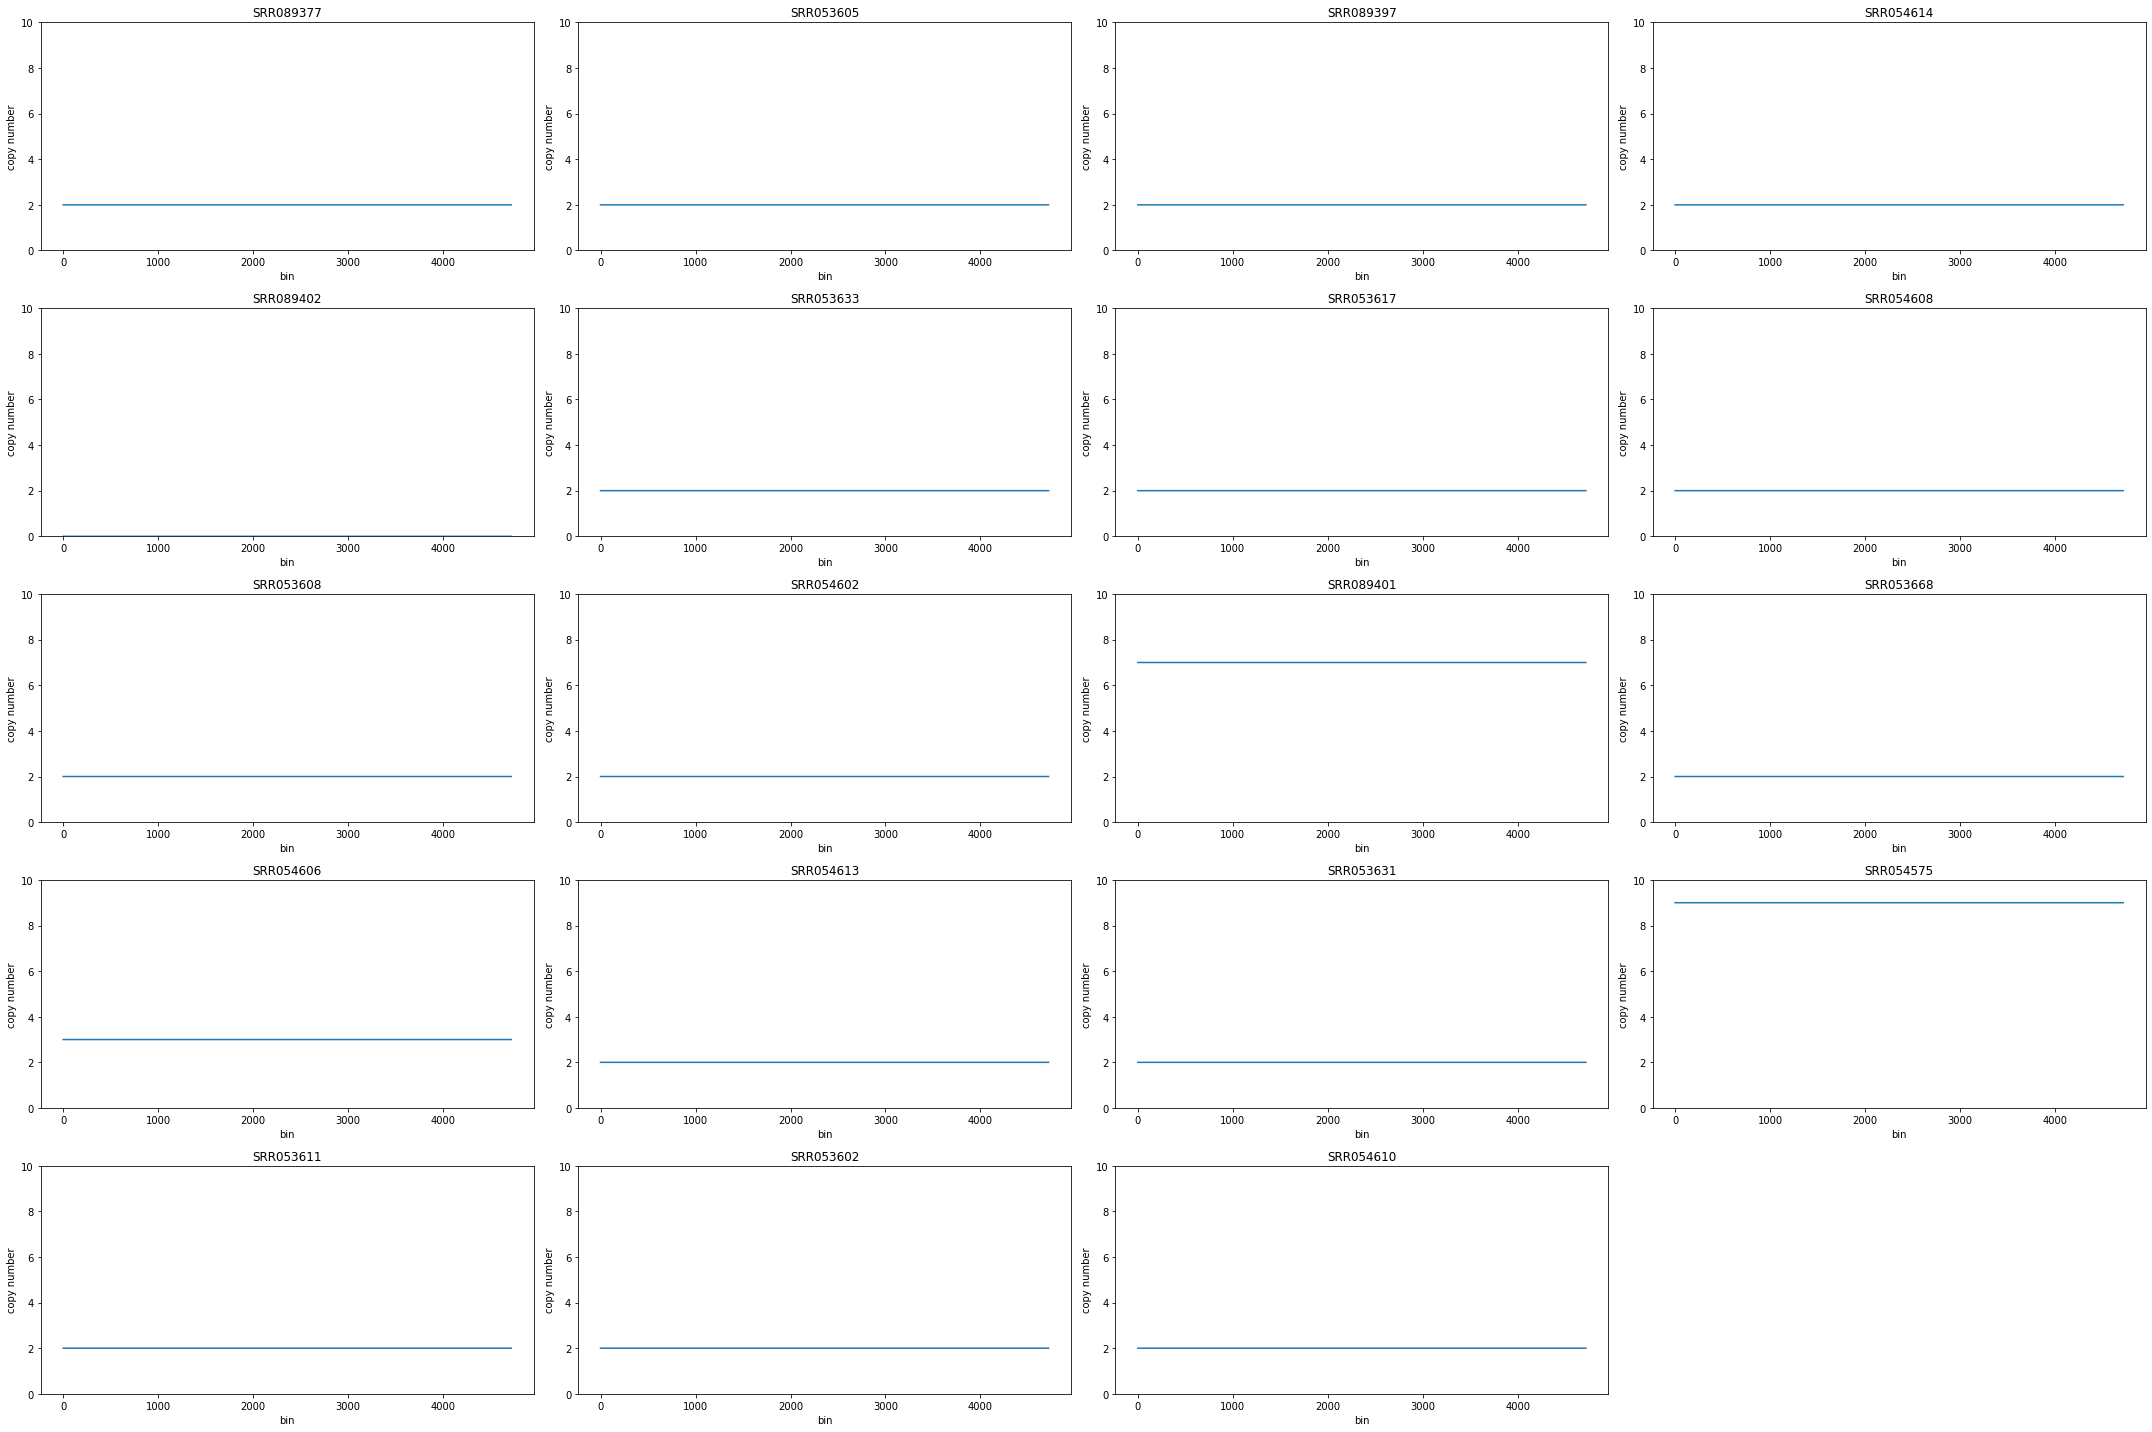

In [549]:
x = visualizeCopyNumbers(C, bins)
num_normal_cells = []
for i in C:
  flag = 0
  for bin in C[i]:
    if C[i][bin] != 2:
      flag = 1
      break
  if flag == 0: num_normal_cells.append(i)

# YOUR CODE HERE
# raise NotImplementedError()

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q2e -- Bonus:_ Extend the plotting function to delineate chromosomes using vertical lines.  [5 points]

- Do not forget to update x-axis labels to show chromosomes.
- The output of 2e should be similar to 2d except with vertical delineations. 
- Generate the plot in the cell below.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

## Question 3: Forward algorithm [10 points]

### _Q3a:_ Compute the marginal log probability of the observations using the forward algorithm. [10 points]

Complete the `forward` and `marginal_log_prob` functions defined below.

Be aware that recurrence of the forward algorithm includes a summation, but we are operating in log space.

You may find `logsumexp` in scipy useful, and you can find more details [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.logsumexp.html).

In [ ]:
def forward(df_norm, cell):
    # Positions
    bins = sorted(list(df_norm.index))

    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    
    # Initialization f[copy_number][bin] = 0
    f = [ { bin : 0 for bin in bins } for c in range(max_copy_number + 1) ]
    
    for idx, bin in enumerate(bins):
        norm_count = float(df_norm.loc[bin][cell])
        # YOUR CODE HERE

        if bin == df_norm.index[0]:
          for s in Q:
            f[s][bin] = initialLogProb(s) + emissionLogProb(s, norm_count)
        else:
          for s in Q:
            sum = 0
            for t in Q:
              sum += f[t][bins[idx-1]] + transitionLogProb(t, s)
          f[s][bin] = emissionLogProb(s, norm_count) + sum

        # raise NotImplementedError()
    return f

def marginal_log_prob(df_norm, f):
    # Positions
    bins = sorted(list(df_norm.index))
    
    # Set of states (copy numbers)
    Q = range(max_copy_number+1)
    last_bin = bins[-1]
    
    marginal_log_probability = 0
    # YOUR CODE HERE

    for s in Q:
      marginal_log_probability += f[s][last_bin]

    # raise NotImplementedError()
    return marginal_log_probability

F = {}
marginal_log_probability = {}
for cell in list(df_norm.columns[3:]):
    F[cell] = forward(df_norm, cell)
    marginal_log_probability[cell] = marginal_log_prob(df_norm, F[cell])
    print(cell, "--", "marginal log prob:", marginal_log_probability[cell])

In [ ]:
print(marginal_log_probability)

In [ ]:
# HIDDEN TEST CELL DO NOT MODIFY


## Question 4: Hierarchical clustering [20 points]
The Python package `scipy` implements hierarchical clustering. We will use this method to perform single linkage cluster with the Manhattan (also known as cityblock) distance metric.

In [527]:
C_labels = list(C.keys())
C_values = [list(C[cell].values()) for cell in C_labels]

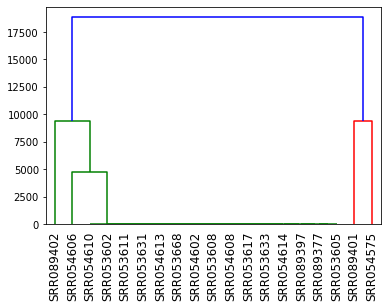

In [528]:
Z = hierarchy.linkage(C_values, 'single', 'cityblock')
init = Z
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

The goal of this question is to reimplement this algorithm. We start by computing the initial distance matrix.

### _Q4a:_ Compute the initial distance matrix using Manhattan distance. [10 points]

In [539]:
def manhattan(C, cell_1, cell_2, bins):
    value = 0
    # YOUR CODE HERE

    for bin in bins:
      value += abs(C[cell_1][bin] - C[cell_2][bin])

    # raise NotImplementedError()
    return value

bins = sorted(list(df_norm.index))
dist = {}
for cell_1 in C.keys():
    dist[cell_1] = {}
    for cell_2 in C.keys():
        dist[cell_1][cell_2] = manhattan(C, cell_1, cell_2, bins)

In [540]:
print(dist)
print(C)

{'SRR089377': {'SRR089377': 0, 'SRR053605': 0, 'SRR089397': 0, 'SRR054614': 0, 'SRR089402': 9436, 'SRR053633': 0, 'SRR053617': 0, 'SRR054608': 0, 'SRR053608': 0, 'SRR054602': 0, 'SRR089401': 23590, 'SRR053668': 0, 'SRR054606': 4718, 'SRR054613': 0, 'SRR053631': 0, 'SRR054575': 33026, 'SRR053611': 0, 'SRR053602': 0, 'SRR054610': 0}, 'SRR053605': {'SRR089377': 0, 'SRR053605': 0, 'SRR089397': 0, 'SRR054614': 0, 'SRR089402': 9436, 'SRR053633': 0, 'SRR053617': 0, 'SRR054608': 0, 'SRR053608': 0, 'SRR054602': 0, 'SRR089401': 23590, 'SRR053668': 0, 'SRR054606': 4718, 'SRR054613': 0, 'SRR053631': 0, 'SRR054575': 33026, 'SRR053611': 0, 'SRR053602': 0, 'SRR054610': 0}, 'SRR089397': {'SRR089377': 0, 'SRR053605': 0, 'SRR089397': 0, 'SRR054614': 0, 'SRR089402': 9436, 'SRR053633': 0, 'SRR053617': 0, 'SRR054608': 0, 'SRR053608': 0, 'SRR054602': 0, 'SRR089401': 23590, 'SRR053668': 0, 'SRR054606': 4718, 'SRR054613': 0, 'SRR053631': 0, 'SRR054575': 33026, 'SRR053611': 0, 'SRR053602': 0, 'SRR054610': 0}, 

In [531]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q4b:_ Implement single linkage clustering. [10 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage

In [532]:
def cluster(distances):
    # distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = None, None, None

        # YOUR CODE HERE

        minimum = float('inf')
        for i in distances:
          for j in distances[i]:
            if j != i and distances[i][j] < minimum:
              minimum = distances[i][j]
              dist = distances[i][j]
              c1 = i
              c2 = j

        # raise NotImplementedError()

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)

        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)

        # YOUR CODE HERE

        distances[new_cluster] = {}
        for i in distances:
          distances[new_cluster][i] = min(distances[c1][i], distances[c2][i])
          distances[i][new_cluster] = distances[new_cluster][i]

        
        for i in distances:
          if c1 in distances[i]:
            del distances[i][c1]
          if c2 in distances[i]:
            del distances[i][c2]

        del distances[c1]
        del distances[c2]

        # raise NotImplementedError()

        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        
        clusters.remove(c1)
        clusters.remove(c2)
        
    return Z, idx2cluster[:n]

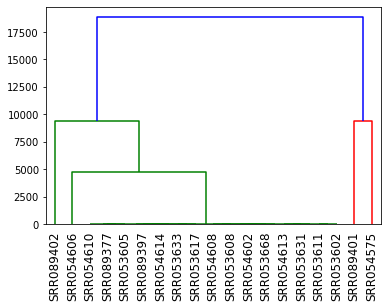

In [533]:
Z, labels = cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

In [534]:
# HIDDEN TEST CELL DO NOT MODIFY


### _Q4c :_ Implement complete linkage clustering. [5 points]
_Hint:_ The documentation for the required output format is described here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage. Your plot should be identical to the below scipy plot.

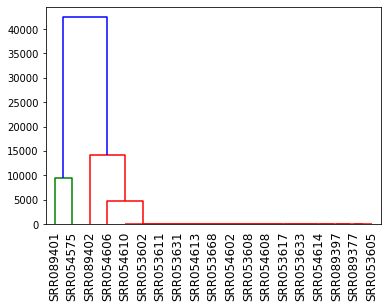

In [541]:
Z = hierarchy.linkage(C_values, 'complete', 'cityblock')
plt.figure()
dn = hierarchy.dendrogram(Z, labels=C_labels, leaf_rotation=90)
plt.show()

In [542]:
def complete_cluster(distances):
    # distances = copy.deepcopy(distances)
    clusters = set(distances.keys())
    n = len(clusters)
    cluster2idx = { cell : idx for idx, cell in enumerate(clusters) }
    idx2cluster = [ cell for cell in clusters ]
    Z = np.empty((0, 4), float)
    membership = [ set([cluster2idx[cell]]) for cell in clusters ]
    while len(clusters) > 1:
        # TODO: identify pair (c1, c2) with minimum distance dist
        dist, c1, c2 = None, None, None
        # YOUR CODE HERE

        minimum = float('inf')
        for i in distances:
          for j in distances[i]:
            if j != i and distances[i][j] < minimum:
              minimum = distances[i][j]
              dist = distances[i][j]
              c1 = i
              c2 = j

        # raise NotImplementedError()

        idx_c1 = cluster2idx[c1]
        idx_c2 = cluster2idx[c2]
        new_cluster = str(n + len(Z))
        new_cluster_idx = len(idx2cluster)
        membership.append( membership[idx_c1] | membership[idx_c2])
        Z = np.append(Z, 
                      np.array([[cluster2idx[c1], cluster2idx[c2], dist, len(membership[new_cluster_idx])]]), 
                      axis=0)
        
        # YOUR CODE HERE

        distances[new_cluster] = {}
        for idx,i in enumerate(distances):
          distances[new_cluster][i] = max(distances[c1][i], distances[c2][i])
          distances[i][new_cluster] = max(distances[c1][i], distances[c2][i])

        
        for i in distances:
          if c1 in distances[i]:
            del distances[i][c1]
          if c2 in distances[i]:
            del distances[i][c2]

        del distances[c1]
        del distances[c2]

        # raise NotImplementedError()
        clusters.add(new_cluster)
        cluster2idx[new_cluster] = len(idx2cluster)
        idx2cluster.append(new_cluster)
        
        clusters.remove(c1)
        clusters.remove(c2)
        
    return Z, idx2cluster[:n]

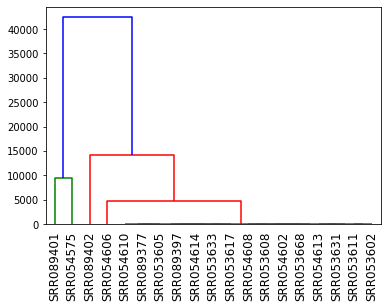

In [543]:
Z, labels = complete_cluster(dist)
plt.figure()
dn = hierarchy.dendrogram(Z, labels=labels, leaf_rotation=90)
plt.show()

In [544]:
# HIDDEN TEST CELL DO NOT MODIFY
